# DenseReg in Tensorflow

In [139]:
import tensorflow as tf
import numpy as np
import cv2
import deepmachine as dm
import scipy.io as sio
import matplotlib.pyplot as plt
from deepmachine import contrib
from scipy.ndimage.filters import gaussian_filter
from menpo.image import Image

%matplotlib inline

### Dataset Visualize

In [7]:
synthetic_pose = '/vol/atlas/databases/tf_records/300w_densereg_600x600.tfrecords'

In [8]:
tf.reset_default_graph()

filename_queue = tf.train.string_input_producer([synthetic_pose])
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

features = tf.parse_single_example(
    serialized_example,
    features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'uv': tf.FixedLenFeature([], tf.string),
        'image': tf.FixedLenFeature([], tf.string),
    })

tf_uv = tf.decode_raw(features['uv'], tf.float32)
tf_image = tf.image.decode_jpeg(features['image'], channels=3)
tf_image = tf.to_float(tf_image)

In [9]:
sess = tf.train.MonitoredSession()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [10]:
image, uv = sess.run([tf_image, tf_uv])

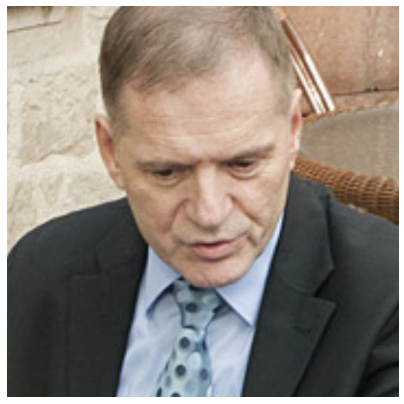

In [11]:
Image.init_from_channels_at_back(image / 255.).view()

In [12]:
uv_img = Image.init_from_channels_at_back(uv.reshape([600,600,3]))

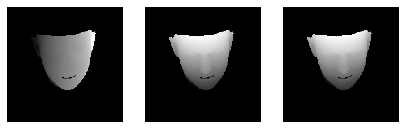

In [13]:
uv_img.view(channels=[0,1,2])

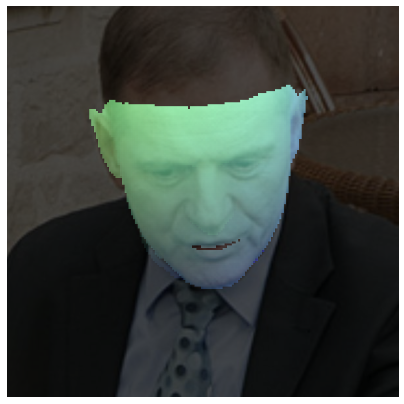

In [14]:
Image.init_from_channels_at_back(image / 255.).view()
Image.init_from_channels_at_back(dm.utils.svs_rgb(uv_img.pixels_with_channels_at_back()[..., :2])).view(alpha=0.7)

### Load Trained Model

In [57]:
model = contrib.densereg.get_densereg_face()

In [59]:
model.restore_path = '/homes/yz4009/db/ckpt_all/Pose/trained/face/densereg_face/model.ckpt-569604'

### Predict Dense Correspondency

In [98]:
input_image = Image.init_from_channels_at_back(image / 255.)
input_image = input_image.resize([256,256])

In [135]:
results = model.run_one(input_image.pixels_with_channels_at_back()[None, ...] * 255.)
# heatmap_image = Image.init_from_channels_at_back(dm.utils.svs_rgb(results[1]['heatmap'][0]))
uv_image = Image.init_from_channels_at_back(results[1]['uv'][0])
uv_mask = ((uv_image.pixels[:11].argmax(axis=0) > 0) + (uv_image.pixels[11:].argmax(axis=0) > 0)) > 0
uv_pixel_f = np.stack([
    gaussian_filter(uv_image.pixels[:11].argmax(axis=0) / 9., 5),
    gaussian_filter(uv_image.pixels[11:].argmax(axis=0) / 9., 5)
], axis=-1) * uv_mask[...,None]

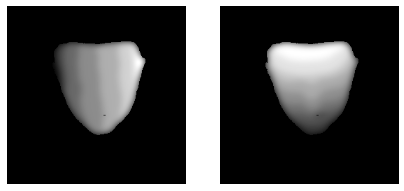

In [136]:
Image.init_from_channels_at_back(uv_pixel_f).view()

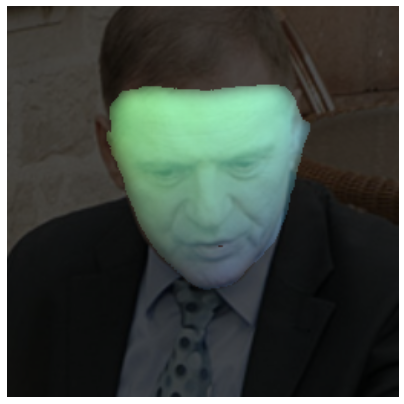

In [137]:
input_image.view()
Image.init_from_channels_at_back(dm.utils.svs_rgb(uv_pixel_f, colour_set='jet')).view(alpha=0.7)

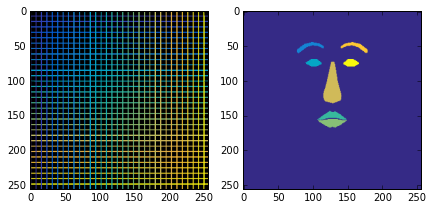

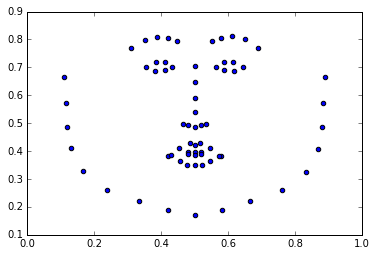

In [146]:
#Read Landmark Coordinates
template_landmarks = np.load('template_data/template_landmarks.npy')
#Read Segmentation Map
L =  sio.loadmat('template_data/SegLabelsColor.mat')
L_segments_color = Image.init_from_channels_at_back(L['L_color']).resize([256,256])
# Read 
L =  sio.loadmat('template_data/Grid_color.mat')
L_grid_color = Image.init_from_channels_at_back(L['Grid_color']).resize([256,256])

# Visualization
f, axarr = plt.subplots(1, 2, figsize=(7,7))
axarr[0].imshow(L_grid_color.pixels_with_channels_at_back())
axarr[1].imshow(L_segments_color.pixels_with_channels_at_back())

plt.figure(2)
plt.scatter(template_landmarks[:,0],template_landmarks[:,1])


#### Interpolate Sparse Information

In [153]:
H = uv_pixel_f[...,0]
V = uv_pixel_f[...,1]
I_resized = input_image.pixels_with_channels_at_back()[None, ...] * 255.

Grid_interpolated = cv2.remap(L_grid_color.pixels_with_channels_at_back() , H * 256., 256. - V * 256.,  interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
Grid_interpolated[Grid_interpolated == 0] = I_resized[Grid_interpolated==0]/255.

Seg_interpolated = cv2.remap(L_segments_color.pixels_with_channels_at_back() , H * 256., 256. - V * 256.,  interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
Seg_interpolated[Seg_interpolated==0] =I_resized[Seg_interpolated==0]/255.

#visualize.
f, axarr = plt.subplots(1, 2, figsize=(11,11))
axarr[0].imshow(Grid_interpolated)
axarr[1].imshow(Seg_interpolated)

error: /home/travis/miniconda/conda-bld/conda_1486587071158/work/opencv-3.1.0/modules/imgproc/src/imgwarp.cpp:4766: error: (-215) ((map1.type() == CV_32FC2 || map1.type() == CV_16SC2) && map2.empty()) || (map1.type() == CV_32FC1 && map2.type() == CV_32FC1) in function remap


In [154]:
L_grid_color.pixels_with_channels_at_back().shape

(256, 256, 3)